# [Hands-On] Understanding Reinforcement Learning and Implementation (Image Version)

- Author : Sangkeun Jung (hugmanskj@gmail.com)

> Educational Purpose

This tutorial illustrates how to train a Deep Q-Network (DQN) on image inputs from the CartPole environment.
Key points include:

- Handling image inputs via ResNet-18 (pretrained)
- Preprocessing and normalizing RGB frames
- Implementing a replay buffer and training loop
- Visualizing intermediate states as images and text, then compiling them into a GIF

# Overview
- Traditional CartPole uses a 4D numeric state: cartposition,cartvelocity,poleangle,poleangularvelocity.
- In this image-based version, we rely on the environment’s raw rendered frames (rgb_array) as inputs.
- A ResNet-18 model (pretrained on ImageNet) is used to extract a 128-dimensional embedding from each frame.
- A fully connected layer then outputs the Q-values for each action (left/right) based on the extracted features.
- This approach generalizes to higher-dimensional visual inputs in reinforcement learning.

## CartPole
- Actions: Move the cart either left (0) or right (1).
- Goal: Prevent the pole from falling over by controlling the cart’s movements.
- Reward: +1 at every timestep the pole remains upright.
- Episode ends when the pole tilts too far or the cart exits the track bounds.

By switching from numeric states to image states, we practice using CNNs (e.g., ResNet) to handle high-dimensional inputs.

# What We'll Build
1. Image Preprocessing:
    - Resize the raw RGB frames to (224×224) and normalize to match ImageNet standards.
2. Neural Network:
    - ResNet-18 (pretrained) as an encoder → 128-d embedding
    - Q-Head: Outputs Q-values for each action
3. Replay Buffer: Stores transitions for mini-batch sampling
4. DQN Training Loop: Epsilon-greedy exploration, Q-target, MSE loss, target network updates, etc.
5. Visualization:
    - Save rendered frames and text info for each timestep
    - Overlay text onto images and create a GIF

# Environment Setup
Install the required packages (if not already installed):

In [ ]:
!pip install gym numpy torch torchvision transformers pillow imageio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

# Required Libraries
Let's import all necessary libraries for our implementation:

In [ ]:
import gymnasium as gym
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import imageio

from torchvision import models, transforms
from collections import deque
from PIL import ImageDraw, ImageFont
from IPython.display import Image as IPyImage

%matplotlib inline

## Key libraries we're using:

- gymnasium: For the CartPole environment
- torch: For neural network implementation
- imageio: For creating visual outputs
- matplotlib: For plotting results

# Neural Network Architecture
## Image Encoder (ResNet-18)
- Pretrained on ImageNet, so it can handle generic natural images.
- feature_extractor: All layers of ResNet-18 minus the final classification FC.
- fc: Outputs a 128-d embedding vector.

In [ ]:
class ResNetEncoder(nn.Module):
   """
   Image Encoder using ResNet-18.
   Takes CartPole's raw image (210x160x3) as input and generates a 128-dimensional feature vector.
   """
   def __init__(self, embed_dim=128):
       super(ResNetEncoder, self).__init__()
       resnet = models.resnet18(pretrained=True)
       self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove last FC layer
       self.fc = nn.Linear(resnet.fc.in_features, embed_dim)  # Transform to 128 dimensions

   def forward(self, x):
       x = self.feature_extractor(x)  # Extract ResNet features
       x = x.view(x.size(0), -1)  # Flatten
       x = self.fc(x)  # Transform to 128 dimensions
       return x

## DQN Network
Our complete DQN combines the encoder with a policy head:

## PolicyNetwork (DQN)

In [ ]:
class DQN(nn.Module):
   """
   ResNet-based Image Encoder + Q-Network.
   """
   def __init__(self, action_dim, embed_dim=128):
       super(DQN, self).__init__()
       self.encoder = ResNetEncoder(embed_dim)  # Feature Extraction using ResNet
       self.q_head = nn.Linear(embed_dim, action_dim)  # Output action Q-values with FC Layer

   def forward(self, x):
       emb = self.encoder(x)
       q = self.q_head(emb)
       return q

forward: Takes the image, extracts features with ResNetEncoder, then outputs Q-values for each action.

# Image Preprocessing Functions

- ResNet expects input based on ImageNet standards (224x224, Normalized values)
- gym's CartPole provides raw images of size (210, 160, 3)
- Convert these to size (224, 224) and apply Normalization

In [ ]:
transform = transforms.Compose([
   transforms.Resize((224, 224)),  # Resize to match ResNet input size
   transforms.ToTensor(),  # Convert (H, W, C) → (C, H, W)
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize based on ImageNet stats
])

def preprocess_image(frame):
   """
   Convert CartPole image (np.array) to Tensor
   """
   img = Image.fromarray(frame)  # Convert numpy array to PIL Image
   img = transform(img)  # Apply transforms
   return img.unsqueeze(0)  # (C, H, W) → (1, C, H, W) (add batch dimension)

# Replay Buffer
The replay buffer is crucial for stable learning in DQN:

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[idx] for idx in batch])

        return (
            torch.stack(states).squeeze(1),  # (batch, 1, C, H, W) → (batch, C, H, W)
            actions,
            rewards,
            torch.stack(next_states).squeeze(1),  # (batch, 1, C, H, W) → (batch, C, H, W)
            dones
        )

    def __len__(self):
        return len(self.buffer)


- push: Stores a single transition ((state, action, reward, next_state, done)).
- sample: Returns a random minibatch of transitions.
- We use .stack() to combine individual image tensors into a batch.

# Training Loop

### store_frames_and_info function
This function stores raw images and step-by-step textual info (e.g., cart position, pole angle) into a folder.

In [ ]:
def store_frames_and_info(episode_number, frames, info_texts, render_path):
   """
   Args:
       episode_number (int): Episode number
       frames (list of np.array): Array of rendered images
       info_texts (list of str): Information strings for each step
       render_path (str): Parent directory path for saving
   """
   ep_folder = os.path.join(render_path, f"episode_{episode_number}")
   os.makedirs(ep_folder, exist_ok=True)

   for i, (img, info_str) in enumerate(zip(frames, info_texts)):
       # step_xxx.png
       png_path = os.path.join(ep_folder, f"step_{i:03d}.png")
       imageio.imwrite(png_path, img)

       # step_xxx.info.txt
       info_path = os.path.join(ep_folder, f"step_{i:03d}.info.txt")
       with open(info_path, "w", encoding="utf-8") as f:
           f.write(info_str)


Below is the main training function. Key steps:

- Initialize environment with render_mode="rgb_array".
- Epsilon-greedy action selection.
- Replay Buffer: Store transitions.
- Minibatch Training: Sample from buffer, compute Q-values, update DQN.
- Target Network: Updated periodically.
- Logging & Visualization: Optionally save each step’s frame + text info.

In [ ]:
def train_dqn(
   env_name="CartPole-v1",
   num_episodes=100,
   batch_size=32,
   gamma=0.99,
   lr=1e-3,
   epsilon_start=1.0,
   epsilon_end=0.01,
   epsilon_decay=500,
   target_update_interval=20,
   buffer_capacity=50000,
   save_render=True,
   render_path="./cartpole_frames"
):
   env = gym.make(env_name, render_mode="rgb_array")
   action_dim = env.action_space.n
   dqn = DQN(action_dim)
   target_dqn = DQN(action_dim)
   target_dqn.load_state_dict(dqn.state_dict())
   optimizer = optim.Adam(dqn.parameters(), lr=lr)
   replay_buffer = ReplayBuffer(capacity=buffer_capacity)
   epsilon = epsilon_start
   epsilon_decay_rate = (epsilon_start - epsilon_end) / epsilon_decay
   total_rewards_list = []

   for episode in range(num_episodes):
       obs, _ = env.reset()
       img_tensor = preprocess_image(env.render())
       done = False
       episode_reward = 0
       episode_frames = []
       episode_info_texts = []
       step_count = 0

       while not done:
           # Epsilon-greedy action selection
           if np.random.rand() < epsilon:
               action = env.action_space.sample()
           else:
               with torch.no_grad():
                   q_values = dqn(img_tensor)
                   action = q_values.argmax(dim=1).item()

           next_obs, reward, done, truncated, _ = env.step(action)
           done = done or truncated
           next_img_tensor = preprocess_image(env.render())
           replay_buffer.push(img_tensor, action, reward, next_img_tensor, done)
           episode_reward += reward
           img_tensor = next_img_tensor

           # ==== Collect rendering and info ====
           if save_render:
               frame = env.render()  # (H, W, 3) numpy
               episode_frames.append(frame)
               # CartPole state (obs[0] = pos, obs[1] = vel, obs[2] = angle, obs[3] = angular vel)
               info_str = (
                   f"Episode={episode+1}, Step={step_count}\n"
                   f"Cart Position={next_obs[0]:.3f}, Cart Velocity={next_obs[1]:.3f}\n"
                   f"Pole Angle={next_obs[2]:.3f}, Pole Angular Vel={next_obs[3]:.3f}\n"
                   f"Action={action}, Reward={reward:.2f}\n"
               )
               episode_info_texts.append(info_str)
           # ============================

           step_count += 1

           # Training
           if len(replay_buffer) > batch_size:
               states, actions, rewards, next_states, dones = replay_buffer.sample(batch_size)
               actions_t = torch.LongTensor(actions).unsqueeze(1)
               rewards_t = torch.FloatTensor(rewards).unsqueeze(1)
               dones_t = torch.BoolTensor(dones).unsqueeze(1)

               q_pred = dqn(states).gather(1, actions_t)
               with torch.no_grad():
                   q_next = target_dqn(next_states).max(dim=1, keepdim=True)[0]
                   q_target = rewards_t + gamma * q_next * (~dones_t)

               loss = F.mse_loss(q_pred, q_target)
               optimizer.zero_grad()
               loss.backward()
               optimizer.step()

               if epsilon > epsilon_end:
                   epsilon -= epsilon_decay_rate

       total_rewards_list.append(episode_reward)

       if (episode + 1) % target_update_interval == 0:
           target_dqn.load_state_dict(dqn.state_dict())

       if (episode + 1) % 10 == 0:
           print(f"[Episode {episode+1}] Reward: {episode_reward}, Epsilon={epsilon:.3f}")
           # Save frames & info
           store_frames_and_info(
               episode_number=episode+1,
               frames=episode_frames,
               info_texts=episode_info_texts,
               render_path=render_path
           )

   env.close()
   return dqn, total_rewards_list

# Visualization Tools
We've implemented comprehensive visualization tools:

- Frame capture during training
- State information overlay
- GIF creation for episode replay

During each episode, we can save frames and text info to see what happens in each step (such as cart position, pole angle, and chosen action).  
We also provide functions to overlay this info onto images and create GIFs, making it easy to visualize the agent’s performance.

In [ ]:
from PIL import Image, ImageDraw, ImageFont
def overlay_text_on_image(image_path, info_path, font_path=None):
   """
   image_path: Path to PNG file
   info_path: Path to corresponding .info.txt file
   font_path: Path to TTF font (optional)
   return: Pillow Image object (image with overlaid text)
   """
   img = Image.open(image_path).convert("RGB")
   draw = ImageDraw.Draw(img)

   # Font setup (use default if not provided)
   if font_path is not None:
       font = ImageFont.truetype(font_path, size=18)
   else:
       font = ImageFont.load_default()

   text = ""
   if os.path.exists(info_path):
       with open(info_path, "r", encoding="utf-8") as f:
           text = f.read()

   # Display multi-line text with line breaks
   lines = text.strip().split("\n")

   # Position setup
   x, y = 10, 10
   padding = 5  # Padding for black box
   max_width = max([draw.textlength(line, font=font) for line in lines]) + 2 * padding
   box_height = len(lines) * 20 + 2 * padding  # Adjust box size based on number of lines

   # Semi-transparent black box (improves readability)
   draw.rectangle([(x - padding, y - padding), (x + max_width, y + box_height)], fill=(0, 0, 0, 150))

   # Add text (yellow)
   for line in lines:
       draw.text((x, y), line, fill=(255, 255, 0), font=font)
       y += 20  # Line spacing

   return img

In [ ]:
def make_gif_with_overlay(ep_folder, output_gif="cartpole_overlay.gif", fps=30, font_path=None):
   """
   ep_folder: Path to 'episode_N' directory (containing PNG & info.txt files)
   output_gif: Path for output GIF file to be created
   font_path: Path to TTF font (uses default font if not provided)
   """
   # Sort PNG files (step_000.png, step_001.png ...)
   file_list = sorted([f for f in os.listdir(ep_folder) if f.endswith(".png")])
   frames = []

   for file_name in file_list:
       image_path = os.path.join(ep_folder, file_name)
       info_path = image_path.replace(".png", ".info.txt")
       # Create image with text overlay
       annotated_img = overlay_text_on_image(image_path, info_path, font_path=font_path)
       frames.append(np.array(annotated_img))  # Convert to numpy array

   if len(frames) > 0:
       imageio.mimsave(output_gif, frames, fps=fps)
       print(f"GIF saved: {output_gif}")
   else:
       print(f"No PNG files found in {ep_folder}.")

#### Running the Training
To train your agent:

In [ ]:
dqn_model, rewards = train_dqn(
    env_name="CartPole-v1",
    num_episodes=500,
    save_render=True,
    render_path="./cartpole_frames"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 128MB/s]


[Episode 10] Reward: 11.0, Epsilon=0.747
[Episode 20] Reward: 32.0, Epsilon=0.244
[Episode 30] Reward: 21.0, Epsilon=0.008
[Episode 40] Reward: 100.0, Epsilon=0.008
[Episode 50] Reward: 18.0, Epsilon=0.008
[Episode 60] Reward: 27.0, Epsilon=0.008
[Episode 70] Reward: 23.0, Epsilon=0.008
[Episode 80] Reward: 24.0, Epsilon=0.008
[Episode 90] Reward: 10.0, Epsilon=0.008
[Episode 100] Reward: 12.0, Epsilon=0.008
[Episode 110] Reward: 9.0, Epsilon=0.008
[Episode 120] Reward: 10.0, Epsilon=0.008
[Episode 130] Reward: 8.0, Epsilon=0.008
[Episode 140] Reward: 39.0, Epsilon=0.008
[Episode 150] Reward: 24.0, Epsilon=0.008
[Episode 160] Reward: 9.0, Epsilon=0.008
[Episode 170] Reward: 11.0, Epsilon=0.008
[Episode 180] Reward: 25.0, Epsilon=0.008
[Episode 190] Reward: 11.0, Epsilon=0.008
[Episode 200] Reward: 11.0, Epsilon=0.008
[Episode 210] Reward: 16.0, Epsilon=0.008
[Episode 220] Reward: 12.0, Epsilon=0.008
[Episode 230] Reward: 23.0, Epsilon=0.008
[Episode 240] Reward: 12.0, Epsilon=0.008
[Ep

In [ ]:
ep_folder = "./cartpole_frames/episode_500"
make_gif_with_overlay(ep_folder, output_gif="cartpole_ep500.gif", fps=30)

GIF saved: cartpole_ep500.gif


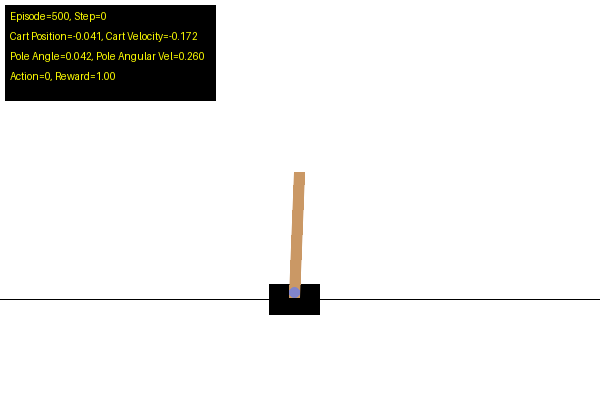

In [ ]:
IPyImage(filename="cartpole_ep500.gif")

# Conclusion

In this tutorial, we implemented a Deep Q-Network (DQN) to handle image inputs in the CartPole environment:

- We used ResNet-18 (pretrained on ImageNet) to encode raw RGB frames into a 128-d feature vector.
- The resulting features were fed into a fully connected layer to produce the Q-values for the two actions.
- Despite its simplicity, this approach showcases how to apply RL algorithms to high-dimensional visual inputs.

## Key Takeaways
1. Image-Based RL:
    - More computationally expensive than using low-dimensional numeric states.
    - Demonstrates the generalization to real-world visual scenarios (e.g., robotics, Atari games, self-driving).
2. Replay Buffer:
    - Essential for stable DQN training.
    - Decouples data collection from network updates.
3. Target Network:
    - Helps stabilize Q-learning by reducing moving-target issues.
    - Update it periodically (e.g., every 20 episodes).
4. Advanced Techniques (future exploration):
    - Frame Stacking (e.g., 4 consecutive frames) to better capture dynamic information.
    - Fine-Tuning the ResNet backbone vs. keeping it frozen.
    - Larger batch sizes, more episodes, or different CNN architectures.